In [0]:
!pip install google-generativeai

  Using cached google_generativeai-0.5.0-py3-none-any.whl (142 kB)
  Using cached google_ai_generativelanguage-0.6.1-py3-none-any.whl (663 kB)
  Using cached google_api_python_client-2.125.0-py2.py3-none-any.whl (12.5 MB)
  Using cached google_auth-2.29.0-py2.py3-none-any.whl (189 kB)
  Using cached google_api_core-2.18.0-py3-none-any.whl (138 kB)
  Using cached proto_plus-1.23.0-py3-none-any.whl (48 kB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Using cached googleapis_common_protos-1.63.0-py2.py3-none-any.whl (229 kB)
  Using cached grpcio_status-1.62.1-py3-none-any.whl (14 kB)
  Using cached grpcio-1.62.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.6 MB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl (9.3 kB)
  Using cached pyasn1_modules-0.4.0-py3-none-any.whl (181 kB)
  Using cached pyasn1-0.6.0-py2.py3-none-any.whl (85 kB)
  Using cached httplib2-0.22.0-py3-none-any.whl (96 kB)
  U

In [0]:
import warnings
warnings.filterwarnings('ignore')

import random
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import sparknlp

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

spark = sparknlp.start()

In [0]:
from profiles import filter_tech_profiles
from preprocessing import preprocess
from stemmer import StemmingPipeline

profiles = spark.read.parquet('/linkedin/people')
technology_ids = filter_tech_profiles(profiles).select(col('id').alias('t_id'))
tech_profiles = profiles \
    .join(technology_ids, profiles.id == technology_ids.t_id, 'inner') \
    .drop('t_id')
preprocessed_profiles = preprocess(tech_profiles).select('id', 'profile_document')
stemmed_profiles = StemmingPipeline('profile_document').transform(preprocessed_profiles)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Normalizer

pipeline = Pipeline(stages=[
    HashingTF(inputCol='stem', outputCol='tf'),
    IDF(inputCol='tf', outputCol='tfidf'),
    Normalizer(inputCol='tfidf', outputCol='features')
])

profile_vectors = pipeline \
    .fit(stemmed_profiles) \
    .transform(stemmed_profiles) \
    .select('id', 'profile_document', 'stem', 'features')
profile_vectors.persist()

Out[7]: DataFrame[id: string, profile_document: string, stem: array<string>, features: vector]

In [0]:
import numpy as np
from sklearn.cluster import KMeans as KMeans
from pyspark.sql.functions import udf
import pickle

path = '/Workspace/Users/roeecohen@campus.technion.ac.il/PROJECT/nn.pkl'

def _get_nn(df, id):
    profile = df.filter(f'id = "{id}"').collect()[0].features

    @udf('double')
    def dot(vec):
        return float(vec.dot(profile))

    return df.withColumn('dist', dot(col('features'))).sort(desc('dist')).limit(31).toPandas()

def find_nn_for_selected(df, ids):
    try:
        nn = pickle.load(open(path, 'rb'))
    except:
        nn = {}
    for id in ids:
        if id not in nn:
            print('creating', id)
            nn[id] = _get_nn(df, id)
            data = np.stack([x.toArray() for x in nn[id]['features']])
            clusters = KMeans(n_clusters=3).fit_predict(data)
            nn[id]['cluster'] = clusters
        else:
            print(id, 'already created')
    pickle.dump(nn, open(path, 'wb'))

find_nn_for_selected(
    profile_vectors,
    [
        'margedady', 
        'venmathi-mark-8105b2104', 
        'angel-fong-161baa112', 
        'miguel-reyes-41162815b'
    ]
)

creating margedady
creating venmathi-mark-8105b2104
creating angel-fong-161baa112
creating miguel-reyes-41162815b


In [0]:
import pickle
import pandas as pd
import numpy as np

path = '/Workspace/Users/roeecohen@campus.technion.ac.il/PROJECT/nn.pkl'
nns = pickle.load(open(path, 'rb'))

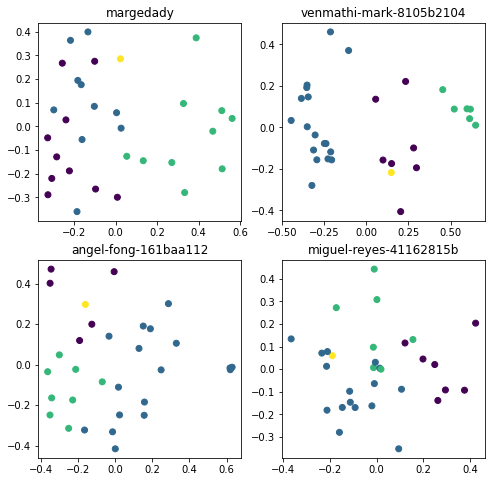

In [0]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
for (id, df), ax in zip(nns.items(), axes):
    data = np.stack([x.toArray() for x in df['features']])
    data = PCA(n_components=2).fit_transform(data)
    colors = [3] + df['cluster'][1:].values.tolist()
    ax.scatter(data[:, 0], data[:, 1], c=colors)
    ax.set_title(id)

In [0]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key='YOUR_API_KEY_HERE')
gemini = genai.GenerativeModel('gemini-pro')

In [0]:
def run_gemini(df):
    texts = ['', '', '']
    for row in df.to_dict('records')[1:]:
        texts[row['cluster']] += row['profile_document'] + '\n'
    prompts = [
    f'''
    Give short answer.
    Below are multiple career paths separated by underscores. Combine them into a single main reasonable path and answer about the imaginary path: What is the job title and give 3 keywords to search for his next job.

    {text}
    '''
    for text in texts]

    responses = [
        gemini.generate_content(prompt)
        for prompt in prompts
    ]
    return [response.text for response in responses]

items = [(id, df) for (id, df) in nns.items()]
gemini_results = [run_gemini(df) for (_, df) in items]

In [0]:
print(
    '\n\n'.join(
        f"""
        # {title}
        Cluster 1
        {responses[0]}
        
        Cluster 2
        {responses[1]}

        Cluster 3
        {responses[2]}
        """

        for responses, (title, _) in zip(gemini_results, items)
    )
)


        # margedady
        Cluster 1
        **Job Title:** Product Manager

**Keywords for next job search:**
- Data Analytics
- Digital Product Management
- Agile Development
        
        Cluster 2
        **Job Title:** Vice President of Product Management

**Keywords for Next Job Search:**

* Product Management
* Digital Marketing
* Business Strategy

I combined multiple career paths that highlighted product management, digital marketing, and strategy, which are all related fields. The titles ranged from Digital Marketing Consultant to Vice President of Product Management. The combined title of Vice President of Product Management reflects the senior level of the roles and responsibilities in the combined career path.

The keywords for the next job search were chosen based on the skills and experience gained throughout the combined career path. Product Management, Digital Marketing, and Business Strategy are all in-demand skills in today's job market. They are also all releva

The job search engine required higher package versions. It was run on local machine. See the `job_search_engine.py` script for the next steps.